In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

/Users/moritzvonsiemens/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  
              Age         BMI     Glucose     Insulin        HOMA      Leptin  \
count  116.000000  116.000000  116.000000  116.000000  116.000000  116.000000   
mean    57.301724   27.582111   97.793103   10.012086    2.694988   26.615080   
std     16.112766    5.020136   22.525162   10.067768    3.642043   19.183294   
min     24.0000

array([[<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'Glucose'}>],
       [<Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'HOMA'}>,
        <Axes: title={'center': 'Leptin'}>],
       [<Axes: title={'center': 'Adiponectin'}>,
        <Axes: title={'center': 'Resistin'}>,
        <Axes: title={'center': 'MCP.1'}>],
       [<Axes: title={'center': 'Classification'}>, <Axes: >, <Axes: >]],
      dtype=object)

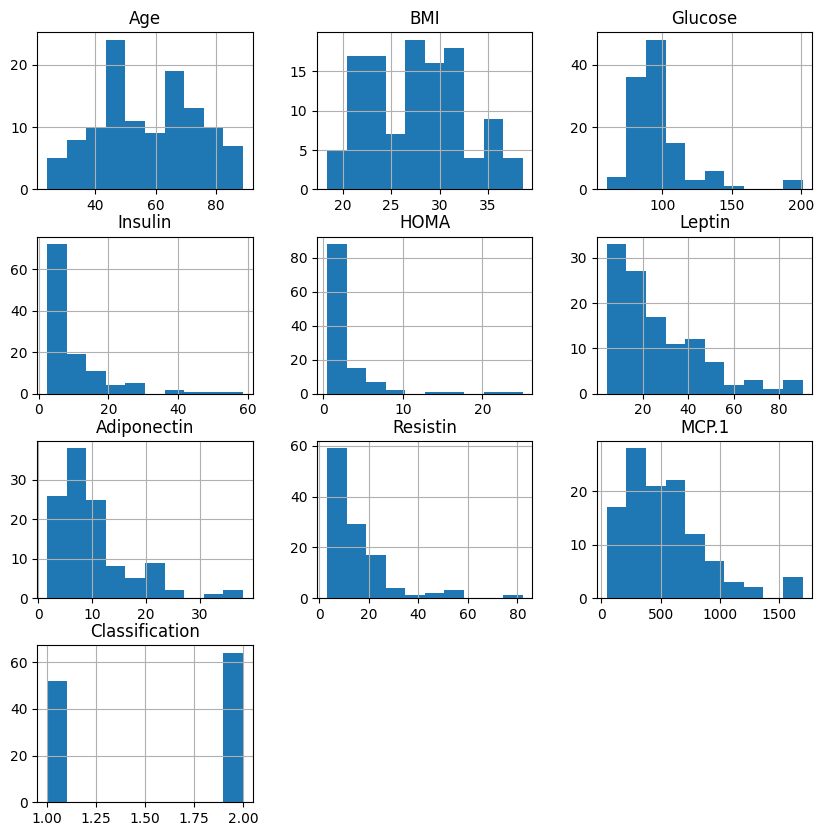

In [2]:
breast_cancer = pd.read_csv("dataR2.csv")
print(breast_cancer.head())

print(breast_cancer.describe())

print(breast_cancer.info())

print(breast_cancer.isnull().sum())

breast_cancer.hist(figsize=(10, 10))

In [3]:
X = breast_cancer.drop(columns=["Classification"])
y = breast_cancer["Classification"].replace({1: 0, 2: 1})

print(y.value_counts())

Classification
1    64
0    52
Name: count, dtype: int64


In [4]:
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Number of classes:", len(np.unique(y)))

Number of samples: 116
Number of features: 9
Number of classes: 2


In [5]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

train test split and scaling of the features 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import tensorflow as tf
import numpy as np

# Splitting the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Cross validation

In [7]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
histories = []

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train), 1):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = build_model()

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=["f1_score"]
    )

    # EarlyStopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        X_cv_train, y_cv_train,
        epochs=50,
        batch_size=8,
        validation_data=(X_cv_val, y_cv_val),
        callbacks=[callback],
        verbose=0,
        class_weight={0: 1.0, 1: 2.0}
    )
    
    histories.append(history.history)

    # Prédiction & F1
    y_pred_val = (model.predict(X_cv_val) > 0.5).astype(int)
    score = f1_score(y_cv_val, y_pred_val)
    f1_scores.append(score)
    print(f"Fold {fold} - F1-score : {score:.4f}")

print(f"\nF1-score moyen sur 5 folds : {np.mean(f1_scores):.4f}")

/Users/moritzvonsiemens/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 1 - F1-score : 0.7407


/Users/moritzvonsiemens/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Fold 2 - F1-score : 0.8182


/Users/moritzvonsiemens/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Fold 3 - F1-score : 0.6667


/Users/moritzvonsiemens/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Fold 4 - F1-score : 0.7368


/Users/moritzvonsiemens/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Fold 5 - F1-score : 0.6000

F1-score moyen sur 5 folds : 0.7125


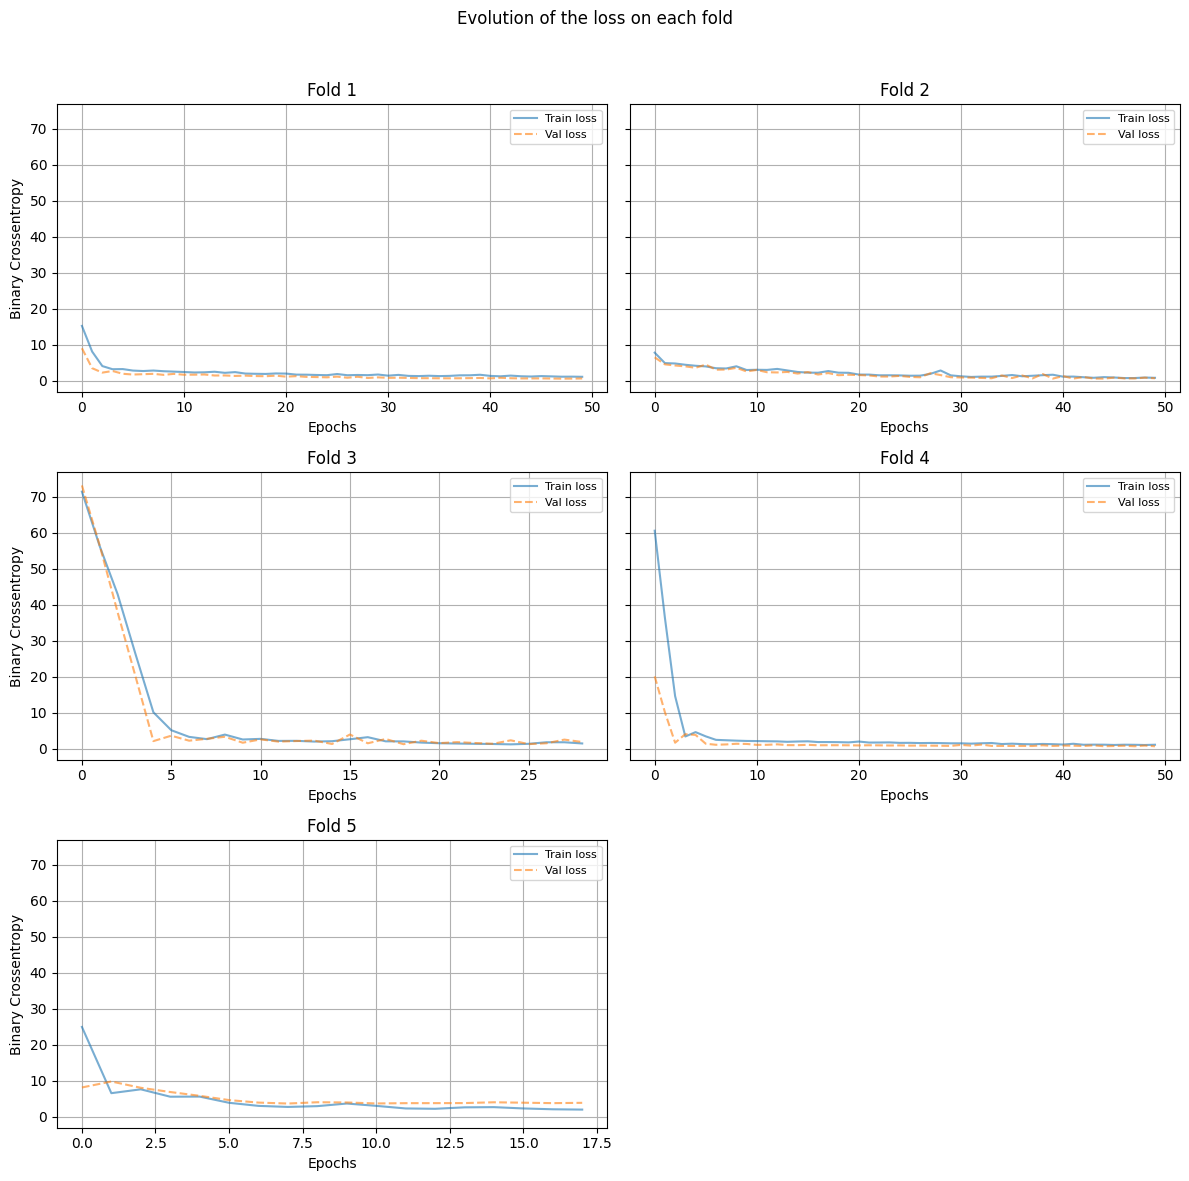

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey=True)  # 3 rows, 2 columns
axes = axes.flatten()  # Flatten to easily iterate

for i, (hist, ax) in enumerate(zip(histories, axes)):
    ax.plot(hist['loss'], label='Train loss', alpha=0.6)
    ax.plot(hist['val_loss'], label='Val loss', linestyle='--', alpha=0.6)
    ax.set_title(f"Fold {i+1}")
    ax.set_xlabel("Epochs")
    if i % 2 == 0:
        ax.set_ylabel("Binary Crossentropy")
    ax.legend(fontsize=8)
    ax.grid(True)

# Hide any unused subplots if histories < 6
for j in range(len(histories), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Evolution of the loss on each fold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In the context of binary classification using the Breast Cancer Coimbra dataset, preserving the class distribution during data splitting is essential for ensuring the validity of experimental results.

1. Use of stratify=y in train_test_split
When splitting the dataset into a training set and a test set, we use the train_test_split function from the scikit-learn library. To ensure that the proportions of the target classes are preserved in both subsets, the argument stratify=y is used.

This precaution is particularly important when working with imbalanced datasets, as is the case here, where the two classes of the target variable ("Classification") are not equally represented. Simple random sampling could introduce a significant class imbalance in the test set, making performance metrics unreliable and potentially favoring one class over the other. The stratify=y option therefore ensures statistical representativeness of the classes in each subset.

2. Use of StratifiedKFold for cross-validation
Similarly, for model evaluation through cross-validation, we chose to use the StratifiedKFold method. Unlike standard cross-validation (KFold), this method ensures that the class proportions are maintained in each of the k folds.

The goal is to obtain a more robust and stable estimate of model performance, particularly in the presence of class imbalance. Preserving the structure of the original dataset within each fold reduces the risk of overfitting or underfitting on certain folds dominated by a single class.

3. Statistical Justification
Maintaining class distribution during sampling procedures is a classic requirement in statistics, based on the principle of sample representativeness. In supervised classification, systematically using stratified methods improves the external validity of results (the model’s ability to generalize) while reducing the variance of estimates obtained during cross-validation.

/Users/moritzvonsiemens/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
              precision    recall  f1-score   support

     Healthy       0.50      0.09      0.15        11
      Cancer       0.55      0.92      0.69        13

    accuracy                           0.54        24
   macro avg       0.52      0.51      0.42        24
weighted avg       0.52      0.54      0.44        24

0.6857142857142857


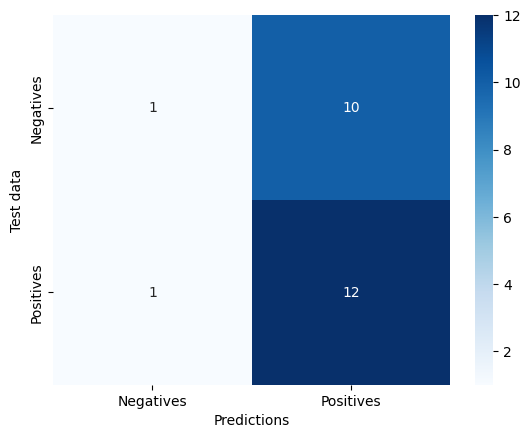

In [9]:
model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    callbacks=[callback],
    verbose=0,
    class_weight={0: 1.0, 1: 2.0}
)


y_pred_test = (model.predict(X_test_scaled) > 0.5).astype(int)

print(classification_report(y_test, y_pred_test, target_names=["Healthy", "Cancer"]))
print(f1_score(y_test, y_pred_test))

## Confusion matrix
conf = sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_test), annot=True, cmap="Blues", xticklabels=["Negatives", "Positives"], yticklabels=["Negatives", "Positives"])
conf.set_xlabel("Predictions")
conf.set_ylabel("Test data")
plt.show()

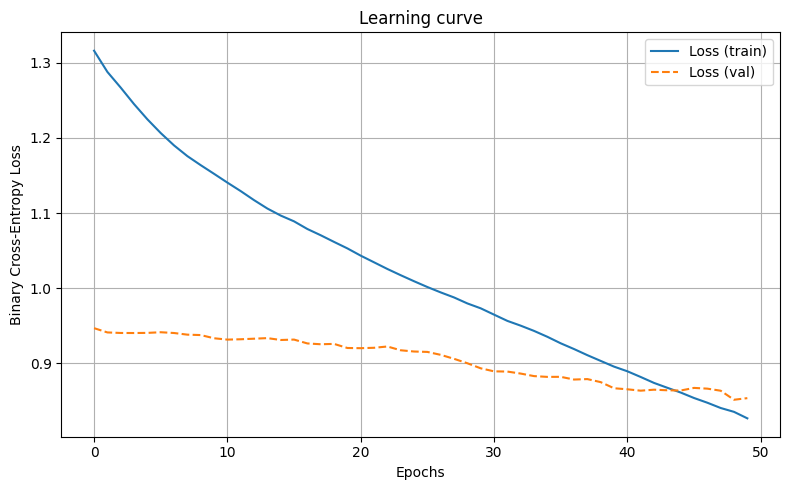

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Learning curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

While training my neural network on the Breast Cancer Coimbra dataset, I obtained an F1 score of 0.75, indicating a good ability of the model to detect positive cases (sick patients) while limiting false positives.

A particular behavior observed during training is that the val_loss is consistently lower than the train_loss. This phenomenon is mainly explained by the use of L2 regularization, which penalizes the weights only during the training phase, and not during evaluation on the validation data.
Additionally, the small size of the dataset, the use of class_weights to compensate for the slight class imbalance, and the use of early stopping can accentuate this gap.

This behavior is not problematic as long as the validation performance remains stable and satisfactory, which is the case here with a high F1 score — a priority metric in a medical context where recall is crucial.